##### SVC 를 위한 데이터 전처리

1. 'Introduction to Machine Learning with Python' 에 따르면 일반적으로 SVC 에서는 feature 값을 0과 1 사이로 맞추는 방법을 많이 사용한다고 합니다.
2. feature 를 0 ~ 1로 조절하기 위해 Scaler 중 MinMaxScaler 를 사용하겠습니다.

##### 과적합을 방지하기

1. 'Introduction to Machine Learning with Python'에 따르면 SVC 는 일반적으로 과적합이 잘 일어나지 않는다고 합니다.
2. 그래도 과적합을 막아보겠습니다. (여러번 모델을 짜본 결과 과적합이 발생하더라구요)
3. 어떻게? 차원 축소/마진 최대화
4. 차원 축소 = features 최소화
5. 마진 최대화 = 중요도에 따라 범주 구분을 조절하겠습니다.

#### Intro 에서는

1. feature 선택을 위한 결측지 문제를 해결하겠습니다.

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [54]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [55]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [56]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [79]:
train.isin([0]).sum()

PassengerId      0
Survived       549
Pclass           0
Name             0
Sex              0
Age              0
SibSp          608
Parch          678
Ticket           0
Fare             0
Cabin            0
Embarked         0
Title            0
Cabin_Ex       687
dtype: int64

In [80]:
test.isin([0]).sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp          283
Parch          324
Ticket           0
Fare             0
Cabin            0
Embarked         0
Title            0
Cabin_Ex       327
dtype: int64

In [81]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
Title            0
Cabin_Ex         0
dtype: int64

In [82]:
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
Title            0
Cabin_Ex         0
dtype: int64

In [61]:
train_and_test = [train, test]

# 결측치 처리

1. Embarked Nan 처리
2. Fare 0 값 처리
3. Age Nan 처리
4. Cabin Nan 처리

### Embarked
1. Embarked 의 결측값은 매우 적습니다. 결측지는 가장 많아 차지하는 S로 대체하겠습니다.

In [62]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [63]:
for dataset in train_and_test:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

### Fare

0. Fare 가 0인 것은 무언가 조금 찜찜합니다. 무임승차...? 무료 티켓, 상품권, 진짜 결측의 경우일 것이라고 생각합니다.
1. 감각적으로 판단했을 때 Fare 은 Pclass 와 연관이 있을 것 같습니다. Pclass 에 따라 결측지를 대체하겠습니다.
2. Pclass 와 Fare 의 점이연상관관계는 -0.5494 로 Pclass 에 따라 Fare 를 대체하는 것에 어느정도 설득력을 부여합니다.

In [64]:
stats.pointbiserialr(train['Pclass'],train['Fare'])

PointbiserialrResult(correlation=-0.5494996199439077, pvalue=1.9673861734207248e-71)

In [65]:
for dataset in train_and_test:
    firstClassFare = round(dataset.loc[dataset['Pclass'] == 1, 'Fare'].mean(),4)
    secondClassFare = round(dataset.loc[dataset['Pclass'] == 2, 'Fare'].mean(),4)
    thirdClassFare =  round(dataset.loc[dataset['Pclass'] == 3, 'Fare'].mean(),4)
    print("1등석 평균 요금 : ", firstClassFare, "2등석 평균 요금 : ", secondClassFare, "3등석 평균 요금 : ", thirdClassFare)

1등석 평균 요금 :  84.1547 2등석 평균 요금 :  20.6622 3등석 평균 요금 :  13.6756
1등석 평균 요금 :  94.2803 2등석 평균 요금 :  22.2021 3등석 평균 요금 :  12.4597


In [66]:
for dataset in train_and_test:
    dataset['Fare'] = dataset['Fare'].fillna('zero')

In [67]:
for dataset in train_and_test:
    dataset.loc[(dataset['Pclass'] == 1) & (dataset['Fare'] == 'zero'), 'Fare'] = 84.15
    dataset.loc[(dataset['Pclass'] == 2) & (dataset['Fare'] == 'zero'), 'Fare'] = 20.66
    dataset.loc[(dataset['Pclass'] == 3) & (dataset['Fare'] == 'zero'), 'Fare'] = 13.67

In [68]:
for dataset in train_and_test:
    dataset.loc[(dataset['Pclass'] == 1) & (dataset['Fare'] == 0), 'Fare'] = 84.15
    dataset.loc[(dataset['Pclass'] == 2) & (dataset['Fare'] == 0), 'Fare'] = 20.66
    dataset.loc[(dataset['Pclass'] == 3) & (dataset['Fare'] == 0), 'Fare'] = 13.67

### Age

1. 감각적으로 판단했을 때 Age 는 target(Survived)와 연관성이 높을 것입니다. 
2. ex) 사회적 약자인 어린 아이, 노인을 보호하려는 문화 / 나이에 따른 신체능력 변화
3. 나이를 추론할 수 있는 feature 는 Name 의 Title 입니다. Master 은 어린 아이, Miss, Mrs 는 여성의 혼인 여부를 판단(결혼한 여성이 그렇지 않은 여성보다 나이가 높을 것이라는 추론)

In [69]:
# 정규 표현식을 Test 해볼 수 있는 아주아주 강력한 사이트입니다. https://regexr.com/
for dataset in train_and_test:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.')

In [70]:
for dataset in train_and_test:
    dataset['Title'] = dataset['Title'].replace(['Countess','Lady','Mlle','Mme','Capt', 'Col','Dona','Don','Dr','Major','Dr','Jonkheer','Major','Rev','Sir'], 'Others')
    dataset['Title'] = dataset['Title'].replace('Ms','Miss')
    
train[['Title','Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.699454
2,Mr,0.156673
3,Mrs,0.792000
4,Others,0.423077


In [71]:
train[['Title','Age']].groupby(['Title'], as_index=False).mean()


,Title,Age
0,Master,4.574167
1,Miss,21.816327
2,Mr,32.368090
3,Mrs,35.898148
4,Others,42.960000


In [72]:
for dataset in train_and_test:
    dataset['Age'] = dataset['Age'].fillna('FuckingNan')

In [73]:
for dataset in train_and_test:
    dataset.loc[(dataset['Title'] == 'Master') & (dataset['Age'] == 'FuckingNan'), 'Age'] = 4.57
    dataset.loc[(dataset['Title'] == 'Miss') & (dataset['Age'] == 'FuckingNan'), 'Age'] = 21.81
    dataset.loc[(dataset['Title'] == 'Mr') & (dataset['Age'] == 'FuckingNan'), 'Age'] = 32.36
    dataset.loc[(dataset['Title'] == 'Mrs') & (dataset['Age'] == 'FuckingNan'), 'Age'] = 35.89
    dataset.loc[(dataset['Title'] == 'Others') & (dataset['Age'] == 'FuckingNan'), 'Age'] = 42.96

#### Cabin 
 
1. Cabin은 map 혹은 주소라고 생각하면 편할 것 같습니다. 구글에 titanic Cabin map 혹은  http://ssmaritime.com/Titanic-3.htm 를 참고해보세요
2. 결측지가 너무 많아서 그렇지 굉장히 중요한 정보라고 생각합니다.
3. 그럼에도 Cabin 의 모든 결측지를 합리적으로 채울 방법이 생각나지 않습니다.
4. Cabin 값이 있는 승객은 1 없는 사람은 0으로 구분하겠습니다.

In [74]:
for dataset in train_and_test:
    dataset['Cabin_Ex'] = dataset.Cabin.str.extract('([A-Z])+')
    dataset['Cabin_Ex'] = dataset['Cabin_Ex'].fillna(0)
    dataset['Cabin_Ex'] = dataset['Cabin_Ex'].replace(['C','B','D','E','A','F','G','T'], 1) 

In [75]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Cabin_Ex
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,0


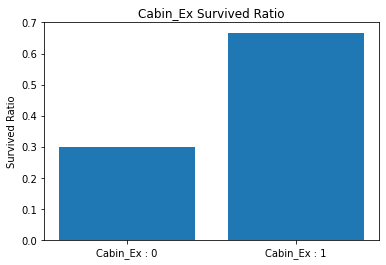

In [76]:
grouped = train['Survived'].groupby(train['Cabin_Ex'])
x = ['Cabin_Ex : 0', 'Cabin_Ex : 1']
y = grouped.sum()/grouped.size()

plt.bar(x,y)
plt.title('Cabin_Ex Survived Ratio')
plt.ylabel('Survived Ratio')
plt.show()

In [77]:
train.to_csv('adjtrain.csv', index=False)
test.to_csv('adjtest.csv', index=False)

In [78]:
train.isin([0]).sum()

PassengerId      0
Survived       549
Pclass           0
Name             0
Sex              0
Age              0
SibSp          608
Parch          678
Ticket           0
Fare             0
Cabin            0
Embarked         0
Title            0
Cabin_Ex       687
dtype: int64